# Getting Started

**Business Problem:** 

Uber Eats has a lot of customers in the Bay Area who have signed up on their platform but have not placed their first order yet. They want to update their marketing campaigns to convert these "non-ordering" customers to place their first order.

As a data scientist at Uber (Hypothetical LOL), my goal is to design, run and analyze an AB experiment that tests two versions of the marketing campaign and to check if the new campaign improved the conversion rate of "non-ordering" customers to place their first order. 

Control - The design of the current marketing campaign is blue in colour and the banner of the campaign is at the bottom of the screen.

Treatment - The design of the new marketing campaign is green in colour and the banner of the campaign is placed right at the top of screen.

GOAL - Help the Marketing team at Uber decide which marketing campaign to use based on the AB test result. 


In [34]:
## Importing Libraries and set seed

# Built-in libraries
from datetime import datetime
import random
import math

# Third-party libraries
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep


# Disable warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Set seed for np random
SEED = 420
np.random.seed(SEED)

## Load Data

In [35]:
# Set data path and load data
data_path = 'Data/'
pretest = pd.read_csv(data_path+'pretest.csv'); print('Pretest Data Imported!')
test = pd.read_csv(data_path+'test.csv'); print('Test Data Imported!')

# Set date fields as date_time
pretest['date'] = pd.to_datetime(pretest['date'])
test['date'] = pd.to_datetime(test['date'])

Pretest Data Imported!
Test Data Imported!


## Exploratory Data Analysis

#### Pretest Data - Marketing Campaign 1

In [36]:
# Pretest Data
pretest.head()

,Customer_ID,date,email,experiment,group,Placed_Order
0,1,2021-01-12,NaN,NaN,NaN,0
1,2,2021-01-12,NaN,NaN,NaN,0
2,3,2021-01-12,NaN,NaN,NaN,0
3,4,2021-01-12,NaN,NaN,NaN,0
4,5,2021-01-12,NaN,NaN,NaN,0


In [37]:
# A. How many rows are in the table?
# B. What's the date range of the date field in the table?
# C. What's the null rate per column?


print('# of rows:', pretest.shape[0])
print('Date range:', pretest.date.min(), '-', pretest.date.max())
print('The null rate per column is:')
pretest.isnull().mean()

# of rows: 309903
Date range: 2021-01-12 00:00:00 - 2021-12-31 00:00:00
The null rate per column is:


Customer_ID     0.000000
date            0.000000
email           0.899017
experiment      0.903070
group           0.903070
Placed_Order    0.000000
dtype: float64

In [38]:
# A. How many customers are there?
# B. How many customers placed their first order?
# C. What was the conversion rate?

print('Total number of customers:', pretest.Customer_ID.nunique())
print('# of customers who placed their first order:', pretest.Placed_Order.sum())
print('Conersion Rate:', pretest.Placed_Order.mean().round(2))

Total number of customers: 309903
# of customers who placed their first order: 31295
Conersion Rate: 0.1


#### Plot1 - # of Converted Customers per day

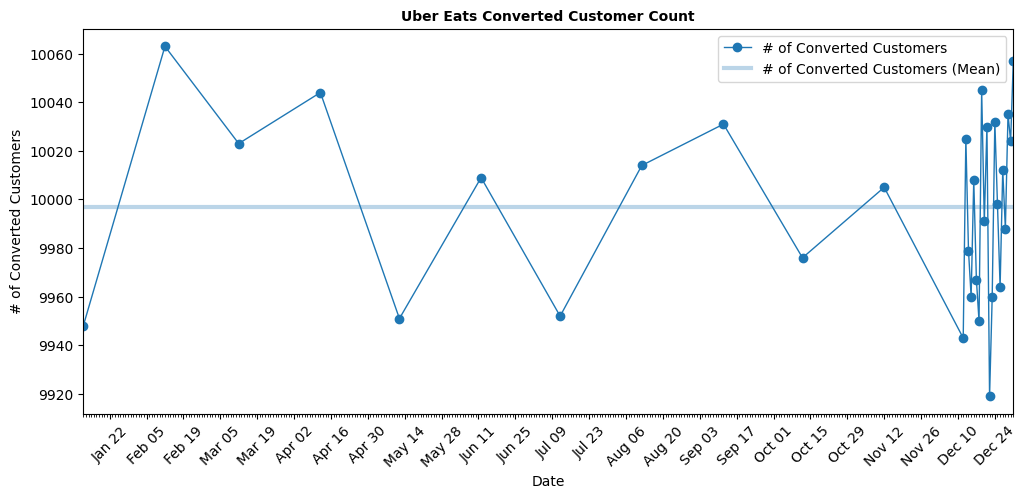

In [39]:
# Set the color palette for the plot
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

# Count number of converted customers by date
CustomerCount_per_day = pretest.groupby('date')['Placed_Order'].count()
CustomerCount_mean = CustomerCount_per_day.mean()

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(CustomerCount_per_day.index, CustomerCount_per_day, '-o', color=c1, linewidth=1, label='# of Converted Customers')
plt.axhline(CustomerCount_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='# of Converted Customers (Mean)')

# Format plot
start_date = min(CustomerCount_per_day.index)  # Get the minimum date in the dataset
ax.set_xlim(start_date, max(CustomerCount_per_day.index))  # Set x-axis limit from the start date to the end date
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('Uber Eats Converted Customer Count', fontsize=10, weight='bold')
plt.ylabel('# of Converted Customers', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.xticks(rotation=45)
plt.legend()

plt.show()

#### Plot2 - Conversion rate per day

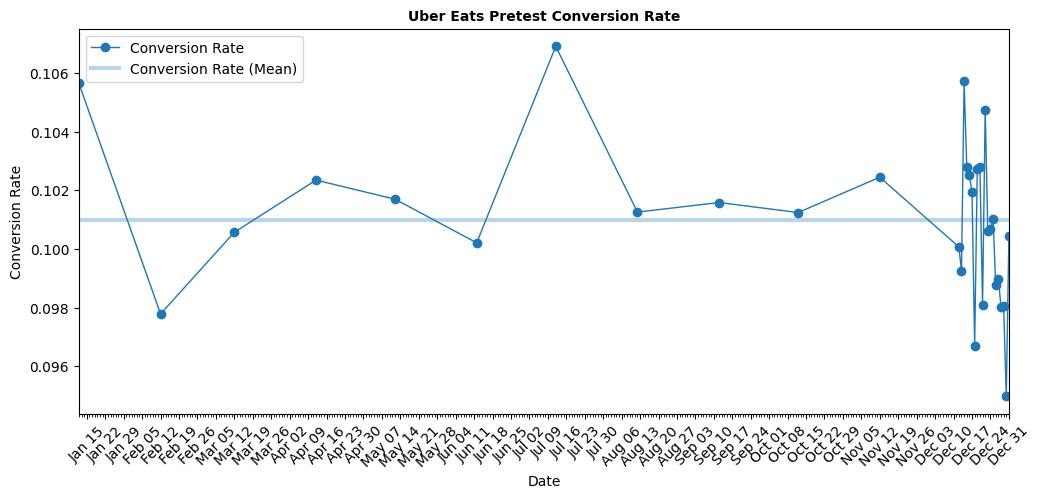

In [40]:
# Conversion rate per date
conversion_rate_per_day = pretest.groupby('date')['Placed_Order'].mean() 
conversion_rate_mean = conversion_rate_per_day.mean() 

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(conversion_rate_per_day.index, conversion_rate_per_day, '-o', color=c1, linewidth=1, label='Conversion Rate')
plt.axhline(conversion_rate_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='Conversion Rate (Mean)')

# Format plot
start_date = min(conversion_rate_per_day.index)  # Get the minimum date in the dataset
ax.set_xlim(start_date, max(conversion_rate_per_day.index))  # Set x-axis limit from the start date to the end date
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('Uber Eats Pretest Conversion Rate', fontsize=10, weight='bold')
plt.ylabel('Conversion Rate', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Step 2 - State the Hypothesis

The second step of the experiment is to state the hypothesis. This is followed by setting parameter values such as the significance level (alpha), statistical power and minimum detctable effect (MDE). 

**Ho:** The conversion rates of blue campaign at the bottom of the screen and green campaign at the top of the screen are the same.<br>
**Ha:** The conversion rates of blue campaign at the bottom of the screen and green campaign at the top of the screen are different.

In [41]:
# Experiment parameters
alpha = 0.05  # Set the probability threshold at 0.05. If the p-value is less than 0.05, reject Ho.
power = 0.80  # Ensure that there's 80% chance of detecting an effect with significance
mde = 0.10    # Detect a 10% improvement of the sign-up rate with statistical significance

# Proportions if the effect exists
p1 = 0.10           # Control   (Campaign1 : Color = Blue, Banner_Location = Bottom)
p2 = p1 * (1 + p1)  # Treatment (Campaign1 : Color = Green, Banner_Location = Top)

# Step 3 - Design the Experiment

The third step of the experiment is the design the experiment which involves determining the randomization unit, calculating the sample size and determining the experiment duration. We will explore how to calculate the sample size and experiment duration in this section.

#### Calculate Sample Size

To detect an effect of 10.0% lift from the pretest conversion at 10%, the sample size per group required is 15000.
The total sample required in the experiment is 30000.


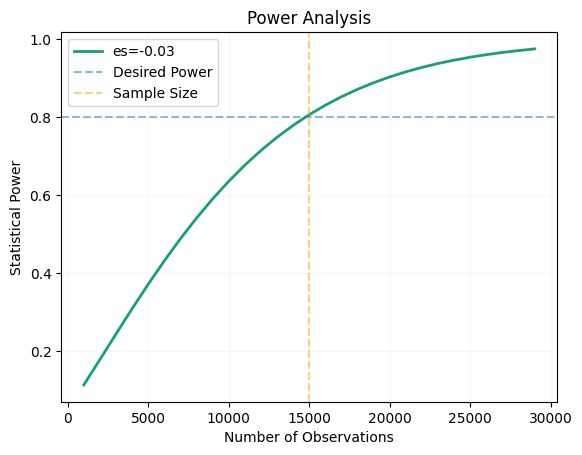

In [42]:
# Calculate the effect size using Cohen's D
cohen_D = sm.stats.proportion_effectsize(p1, p2)

# Estimate the sample size required per group
n = tt_ind_solve_power(effect_size=cohen_D, power=power, alpha=alpha)
n = int(round(n, -3)) # Round up to the nearest thousand

print(f'To detect an effect of {100*(p2/p1-1):.1f}% lift from the pretest conversion at {100*p1:.0f}%, '
      f'the sample size per group required is {n}.'
      f'\nThe total sample required in the experiment is {2*n}.')

# Explore power across sample sizes
ttest_power = TTestIndPower()
ttest_power.plot_power(dep_var='nobs', nobs=np.arange(1000,30000,1000), effect_size=[cohen_D], title='Power Analysis')

# Set plot parameters
plt.axhline(0.8, linestyle='--', label='Desired Power', alpha=0.5)
plt.axvline(n, linestyle='--', color='orange', label='Sample Size', alpha=0.5)
plt.ylabel('Statistical Power')
plt.grid(alpha=0.08)
plt.legend()
plt.show()

#### Experiment Duration

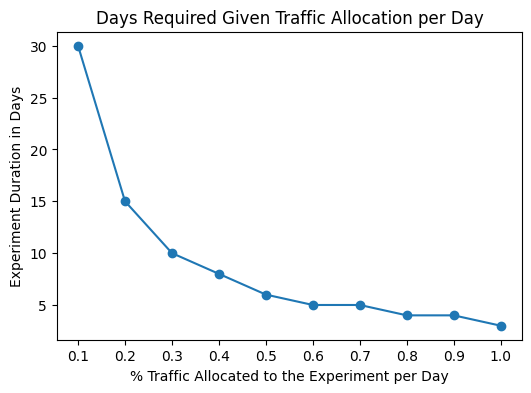

In [43]:
# what's the duration required to achieve the required sample size given the 
# percentage of unique visitors allocated to the experiment?

alloc = np.arange(0.10,1.1,0.10)
size = round(CustomerCount_mean, -3) * alloc
days = np.ceil(2*n / size)

# Generate plot
f, ax = plt.subplots(figsize=(6, 4))
ax.plot(alloc, days, '-o')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_title('Days Required Given Traffic Allocation per Day')
ax.set_ylabel('Experiment Duration in Days')
ax.set_xlabel('% Traffic Allocated to the Experiment per Day')
plt.show()

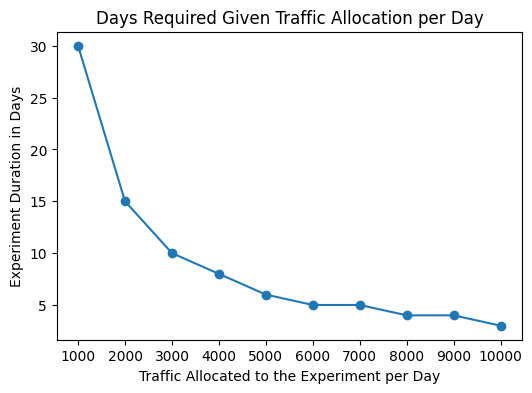

In [44]:
# what's the duration required to achieve the required sample size given the 
# number of unique visitors allocated to the experiment?

f, ax = plt.subplots(figsize=(6, 4))
ax.plot(size, days, '-o')
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.set_title('Days Required Given Traffic Allocation per Day')
ax.set_ylabel('Experiment Duration in Days')
ax.set_xlabel('Traffic Allocated to the Experiment per Day')
plt.show()

In [47]:
# Display the number of users required per day in an experiment given the experiment duration.
print(f'For a 21-day experiment, {np.ceil(n * 2 / 21)} users are required per day') # Too long to wait
print(f'For a 14-day experiment, {np.ceil(n * 2 / 14)} users are required per day') # Sweet spot between risk and time
print(f'For a 7-day experiment, {np.ceil(n * 2 / 7)} users are required per day')   # Too risky

For a 21-day experiment, 1429.0 users are required per day
For a 14-day experiment, 2143.0 users are required per day
For a 7-day experiment, 4286.0 users are required per day


# Step 4 - Design the experiment

We will take a look at the step that involves running an experiment. The code below a simplified version of how data is collected and analyzed in a large scale experiment platform.

In [46]:
# Get the subset tables of control and treatment results
AB_test = test[test.experiment == 'campaign_test']
control_signups = AB_test[AB_test.group == 0]['Placed_Order']
treatment_signups = AB_test[AB_test.group == 1]['Placed_Order']

# Get stats 
AB_control_cnt = control_signups.sum()          # Control Sign-Up Count
AB_treatment_cnt = treatment_signups.sum()      # Treatment Sign-Up Count
AB_control_rate = control_signups.mean()        # Control Sign-Up Rate
AB_treatment_rate = treatment_signups.mean()    # Treatment Sign-Up Rate
AB_control_size = control_signups.count()       # Control Sample Size 
AB_treatment_size = treatment_signups.count()   # Treatment Sample Size

# Show calculation
print(f'Control Sign-Up Rate: {AB_control_rate:.4}')
print(f'Treatment Sign-Up Rate: {AB_treatment_rate:.4}')

Control Sign-Up Rate: 0.09557
Treatment Sign-Up Rate: 0.1078


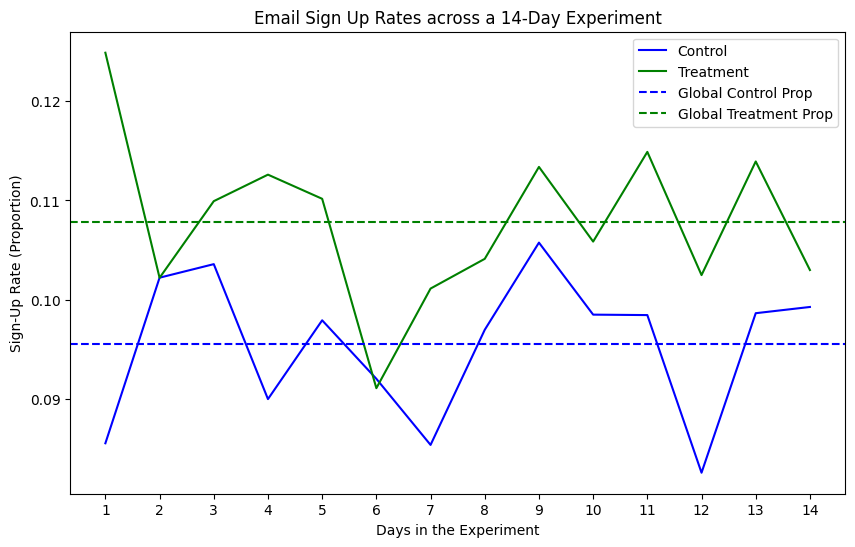

In [50]:
# Calculate the sign-up rates per date
signups_per_day = AB_test.groupby(['group','date'])['Placed_Order'].mean()
ctrl_props = signups_per_day.loc[0]
trt_props = signups_per_day.loc[1]

# Get the day range of experiment
campaign_test = test[test.experiment == 'campaign_test']
exp_days = range(1, campaign_test['date'].nunique() + 1)

# Let's display the sign-up rate per experiment day
f, ax = plt.subplots(figsize=(10, 6))
# Generate plots
ax.plot(exp_days, ctrl_props, label='Control', color='b')
ax.plot(exp_days, trt_props, label='Treatment', color='g')
ax.axhline(AB_control_rate, label='Global Control Prop', linestyle='--', color='b')
ax.axhline(AB_treatment_rate, label='Global Treatment Prop', linestyle='--', color='g')

# # Format plot
ax.set_xticks(exp_days)
ax.set_title('Email Sign Up Rates across a 14-Day Experiment')
ax.set_ylabel('Sign-Up Rate (Proportion)')
ax.set_xlabel('Days in the Experiment')
ax.legend()
plt.show()

# Step 5 - Assess Validity Threats

In this step I will check for two of the checks for validity threats, which involve the AA test and the chi-square test for sample ratio mismatch (SRM).

Conducting checks for the experiment ensures that the AB test result is trustworthy and reduces risk of committing type 1 or 2 errors.

I run an AA test to ensure that there is no underlying difference between
the control and treatment to begin with. Note that in an actual experiment,
AA test would be conducted prior to the AB test. 

I run a chi-square test on group sizes to check for sample-ratio mismatch (SRM). This test ensures that the randomization algorithm worked

There are other potential checks that could be performed including segmentation analysis to perform novelty checks and such. 

But, for this exercise, I will keep it simple to just two checks.

## AA Test

In [51]:
# Let's conduct an AA test

# Filter on visitors in the AA test 
AA_test = pretest[pretest.experiment == 'AA_test']

# Grab the control and treatment groups in the AA test
AA_control = AA_test[AA_test.group == 0]['Placed_Order']
AA_treatment = AA_test[AA_test.group == 1]['Placed_Order']

# Get stats
AA_control_cnt = AA_control.sum()
AA_treatment_cnt = AA_treatment.sum()
AA_control_rate = AA_control.mean()
AA_treatment_rate = AA_treatment.mean()
AA_control_size = AA_control.count()
AA_treatment_size = AA_treatment.count()

# Show calculation
print('-------- AA Test ----------')
print(f'Control Sign-Up Rate: {AA_control_rate:.3}')
print(f'Treatment Sign-Up Rate: {AA_treatment_rate:.3}')

-------- AA Test ----------
Control Sign-Up Rate: 0.101
Treatment Sign-Up Rate: 0.0988


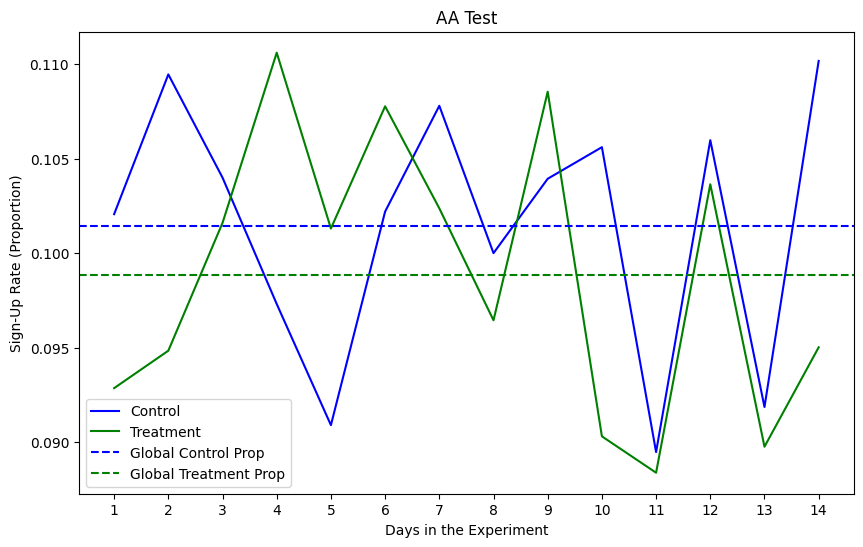

In [52]:
# Sign-up rates per date
AA_signups_per_day = AA_test.groupby(['group','date'])['Placed_Order'].mean()
AA_ctrl_props = AA_signups_per_day.loc[0]
AA_trt_props = AA_signups_per_day.loc[1]

# Get the day range of experiment
exp_days = range(1, AA_test['date'].nunique() + 1)

# Let's display the sign-up rate per experiment day
f, ax = plt.subplots(figsize=(10, 6))
# Generate plots
ax.plot(exp_days, AA_ctrl_props, label='Control', color='b')
ax.plot(exp_days, AA_trt_props, label='Treatment', color='g')
ax.axhline(AA_control_rate, label='Global Control Prop', linestyle='--', color='b')
ax.axhline(AA_treatment_rate, label='Global Treatment Prop', linestyle='--', color='g')

# # Format plot
ax.set_xticks(exp_days)
ax.set_title('AA Test')
ax.set_ylabel('Sign-Up Rate (Proportion)')
ax.set_xlabel('Days in the Experiment')
ax.legend()
plt.show()

In [53]:
# Run a chi-square test

# Execute test
AA_chistats, AA_pvalue, AA_tab = proportions_chisquare([AA_control_cnt, AA_treatment_cnt], nobs=[AA_control_size, AA_treatment_size])

# Grab dates
first_date = AA_test['date'].min().date()
last_date = AA_test['date'].max().date()

# Set the ALPHA for the AA test
AA_ALPHA = 0.05

print(f'-------- AA Test ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between blue campaign at the bottom of the screen and green campaign at the top of the screen are the same.')
print('Ha: The sign-up rates between blue campaign at the bottom of the screen and green campaign at the top of the screen are different.\n')
print(f'Significance level: {AA_ALPHA}')

print(f'Chi-Square = {AA_chistats:.3f} | P-value = {AA_pvalue:.3f}')

print('\nConclusion:')
if AA_pvalue < AA_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference between the two groups. Check for instrumentation errors.')
else:
  print('Fail to reject Ho. Therefore, proceed with the AB test.')

-------- AA Test (2021-12-18 - 2021-12-31)---------

Ho: The sign-up rates between blue campaign at the bottom of the screen and green campaign at the top of the screen are the same.
Ha: The sign-up rates between blue campaign at the bottom of the screen and green campaign at the top of the screen are different.

Significance level: 0.05
Chi-Square = 0.577 | P-value = 0.448

Conclusion:
Fail to reject Ho. Therefore, proceed with the AB test.


## Sample Ration Mismatch (SRM)

In [54]:
# Let's check for sample ratio mismatch (SRM) 

# Set test param
SRM_ALPHA = 0.05

# Get the observed and expected counts in the experiment
campaign_test = test[test.experiment == 'campaign_test']
observed = campaign_test.groupby('group')['experiment'].count().values
expected = [campaign_test.shape[0]*0.5]*2

# perform Chi-Square Goodness of Fit Test
chi_stats, pvalue = stats.chisquare(f_obs=observed, f_exp=expected)

print('------- A Chi-Square Test for SRM --------\n')
print('Ho: The ratio of samples is 1:1.')
print('Ha: The ratio of samples is not 1:1.\n')
print(f'Significance level: {SRM_ALPHA}')

print(f'Chi-Square = {chi_stats:.3f} | P-value = {pvalue:.3f}')

print('\nConclusion:')
if pvalue < SRM_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the ratio of samples not being 1:1. Therefore, there is SRM.')
else:
  print('Fail to reject Ho. Therefore, there is no SRM.')

------- A Chi-Square Test for SRM --------

Ho: The ratio of samples is 1:1.
Ha: The ratio of samples is not 1:1.

Significance level: 0.05
Chi-Square = 1.290 | P-value = 0.256

Conclusion:
Fail to reject Ho. Therefore, there is no SRM.


# Step 6 - Conduct Statistical Inference

In this step I will walk through the procedure of applying statistical tests on the customer sign-up AB test. We will take a look at Chi-Squared and T-Test to evaluate the results from the experiment. Though, in real life, only one of the tests is sufficient, for learning, it's useful to compare and contrast the result from both.

I will end this step by looking at the confidence interval.

In [55]:
# Set the ALPHA for the AB test
AB_ALPHA = 0.05

## Chi Squared Test

In [56]:
# Let's start with the chi-squared test

# Execute test
AB_chistats, AB_pvalue, AB_tab = proportions_chisquare([AB_control_cnt, AB_treatment_cnt], nobs=[AB_control_size, AB_treatment_size])

# Grab dates
first_date = AB_test['date'].min().date()
last_date = AB_test['date'].max().date()

# Run results
print(f'-------- AB Test Email Sign-Ups ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between blue campaign at the bottom of the screen and green campaign at the top of the screen are the same.')
print('Ha: The sign-up rates between blue campaign at the bottom of the screen and green campaign at the top of the screen are different.\n')
print(f'Significance level: {AB_ALPHA}')

print(f'Chi-Square = {AB_chistats:.3f} | P-value = {AB_pvalue:.3f}')

print('\nConclusion:')
if AB_pvalue < AB_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.')
else:
  print('Fail to reject Ho.')

-------- AB Test Email Sign-Ups (2022-01-02 - 2022-12-02)---------

Ho: The sign-up rates between blue campaign at the bottom of the screen and green campaign at the top of the screen are the same.
Ha: The sign-up rates between blue campaign at the bottom of the screen and green campaign at the top of the screen are different.

Significance level: 0.05
Chi-Square = 12.312 | P-value = 0.000

Conclusion:
Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.


## T-Test for proportions

In [57]:
# Let's run T-Test for Proportions

# Execute test
AB_tstat, AB_pvalue, AB_df = ttest_ind(treatment_signups, control_signups)

# Grab dates
first_date = AB_test['date'].min().date()
last_date = AB_test['date'].max().date()

# Print results
print(f'-------- AB Test Email Sign-Ups ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between blue campaign at the bottom of the screen and green campaign at the top of the screen are the same.')
print('Ha: The sign-up rates between blue campaign at the bottom of the screen and green campaign at the top of the screen are different.\n')
print(f'Significance level: {AB_ALPHA}')

print(f'T-Statistic = {AB_tstat:.3f} | P-value = {AB_pvalue:.3f}')

print('\nConclusion:')
if AB_pvalue < AB_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.')
else:
  print('Fail to reject Ho.')

-------- AB Test Email Sign-Ups (2022-01-02 - 2022-12-02)---------

Ho: The sign-up rates between blue campaign at the bottom of the screen and green campaign at the top of the screen are the same.
Ha: The sign-up rates between blue campaign at the bottom of the screen and green campaign at the top of the screen are different.

Significance level: 0.05
T-Statistic = 3.509 | P-value = 0.000

Conclusion:
Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.


## Final Result w/ Confidence Interval

In [58]:
# Compute the Confidence Interval of the Test
ci = confint_proportions_2indep(AB_treatment_cnt, AB_treatment_size, AB_control_cnt, AB_control_size, method=None, compare='diff', alpha=0.05, correction=True)
lower = ci[0]
upper = ci[1]
lower_lift = ci[0] / AB_control_rate
upper_lift = ci[1] / AB_control_rate

In [59]:
# Print results
print('--------- Sample Sizes ----------')
print(f'Control: {AB_control_size}')
print(f'Treatment: {AB_treatment_size}')

print('\n--------- Sign-Up Counts (Rates) ----------')
print(f'Control: {AB_control_cnt} ({AB_control_rate*100:.1f}%)')
print(f'Treatment: {AB_treatment_cnt} ({AB_treatment_rate*100:.1f}%)')

print('\n--------- Differences ----------')
print(f'Absolute: {AB_treatment_rate - AB_control_rate:.4f}')
print(f'Relative (lift): {(AB_treatment_rate - AB_control_rate) / AB_control_rate*100:.1f}%')

print('\n--------- T-Stats ----------')
print(f'Test Statistic: {AB_tstat:3f}')
print(f'P-Value: {AB_pvalue:.5f}')

print('\n--------- Confidence Intervals ----------')
print(f'Absolute Difference CI: ({lower:.3f}, {upper:.3f})')
print(f'Relative Difference (lift) CI: ({lower_lift*100:.1f}%, {upper_lift*100:.1f}%)')

--------- Sample Sizes ----------
Control: 14942
Treatment: 15139

--------- Sign-Up Counts (Rates) ----------
Control: 1428 (9.6%)
Treatment: 1632 (10.8%)

--------- Differences ----------
Absolute: 0.0122
Relative (lift): 12.8%

--------- T-Stats ----------
Test Statistic: 3.509475
P-Value: 0.00045

--------- Confidence Intervals ----------
Absolute Difference CI: (0.005, 0.019)
Relative Difference (lift) CI: (5.7%, 19.9%)


# Step 7 - Decide Whether to Launch

In the customer sign-up test for Uber Eats' new campaign banner, we aimed to improve the conversion rate of non-ordering customers to place their first order by changing the campaign color from blue to green and moving its position from the bottom of the screen to the top of the screen.

We ran a two-week randomized controlled experiment (02/01/2022 - 02/14/2022) that enrolled a sample of users into the control (Color = blue, Position = bottom) and treatment (Color = green, Position = top) groups.

From the test, we observed an improvement of 12.8% lift from the benchmark (blue) at 9.6%. The result was statistically significant with a 95% confidence interval between 5.7% and 19.9%. 

Given that we observed practical and statistical significance, our recommendation is to launch the the new campaign!